In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from features import *
from utils import plot_curves

In [3]:
data = pd.read_pickle('data/data.pkl')

In [4]:
train, val, test = train_val_test_split(data)

In [5]:
y_train = get_target(train)
y_val = get_target(val)
y_test = get_target(test)



  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:16<07:37, 76.24s/it]

 29%|██▊       | 2/7 [02:32<06:21, 76.25s/it]

 43%|████▎     | 3/7 [03:52<05:08, 77.24s/it]

 57%|█████▋    | 4/7 [05:14<03:56, 78.94s/it]

 71%|███████▏  | 5/7 [06:48<02:46, 83.21s/it]

 86%|████████▌ | 6/7 [08:42<01:32, 92.63s/it]

MemoryError: 

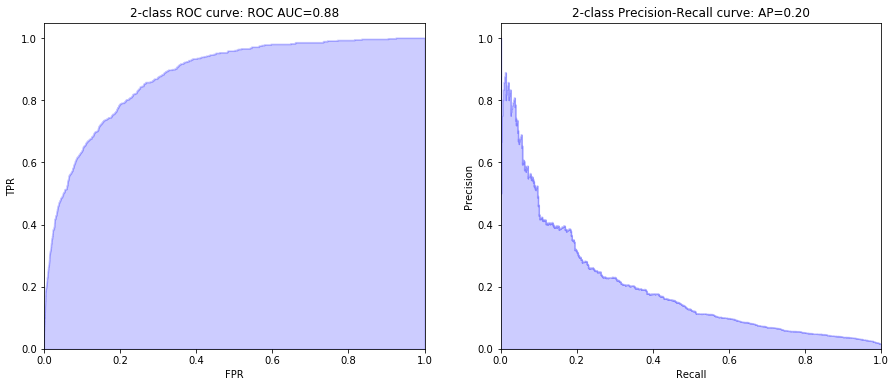

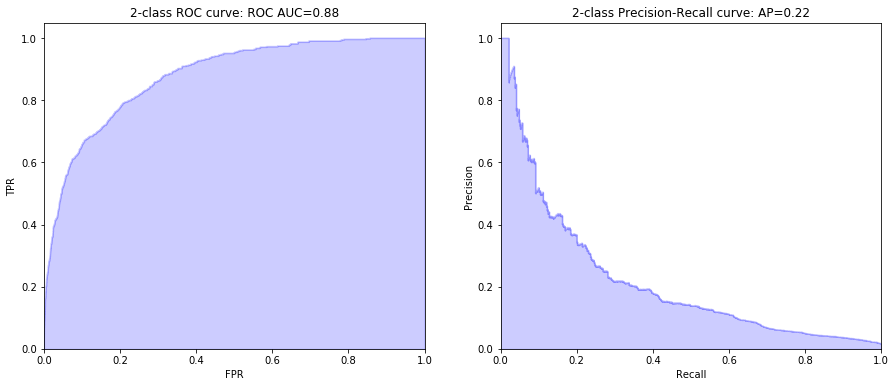

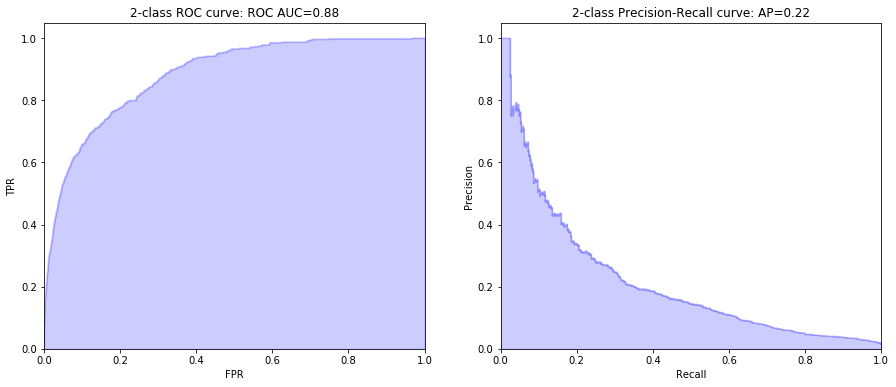

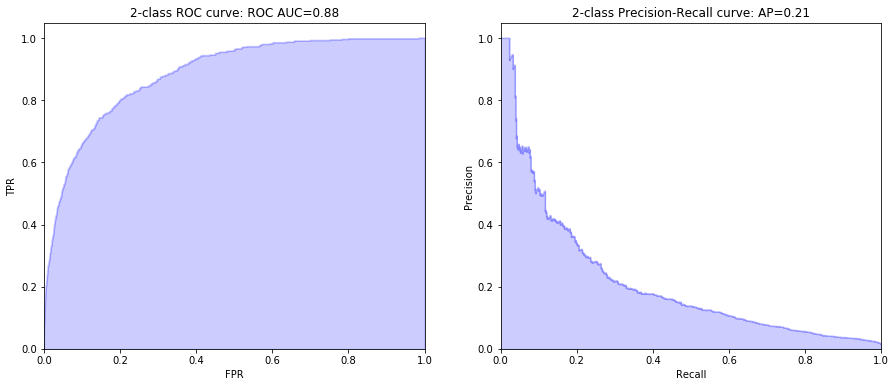

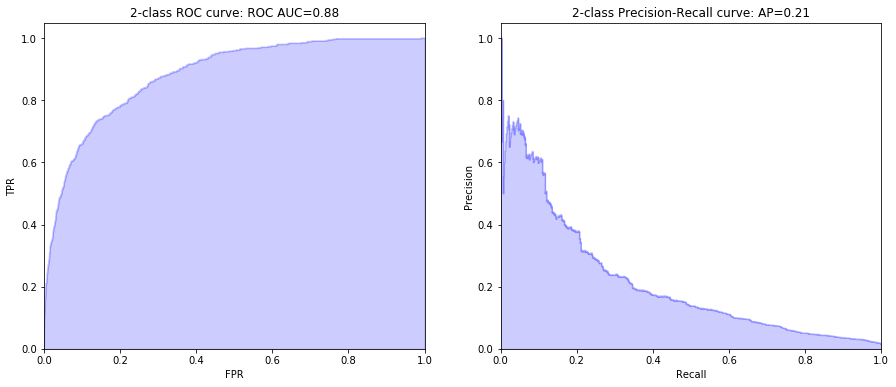

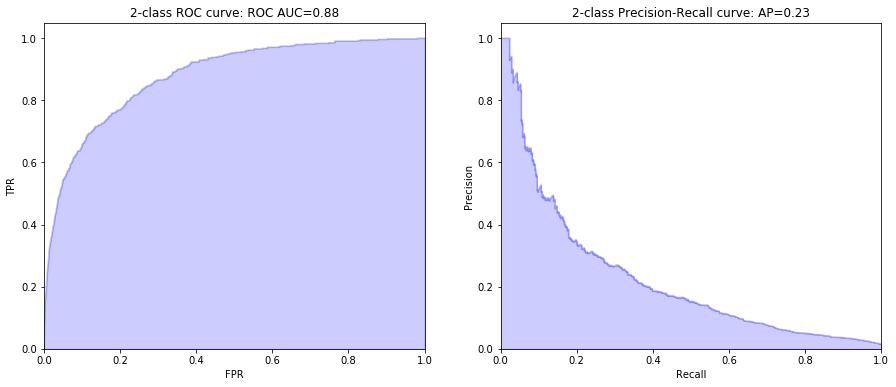

In [18]:
results = []
for max_number in tqdm([15000, 12000, 9000, 6000, 3000, 1000, 100]):
    model = Categorizer(max_number=max_number)
    model.fit(train, on='cost')

    train['cost_cluster'] = model.predict(train)
    val['cost_cluster'] = model.predict(val)
#     test['cost_cluster'] = model.predict(test)

    train_sent = sentences(train, on='cost_cluster')
    val_sent = sentences(val, on='cost_cluster')
#     test_sent = sentences(test, on='cost_cluster')
    
    X_train, X_val, X_test = transform_tf_idf(
        train_sent, val_sent,
        col_name='cost_cluster')
    
    y_train_upd = pd.merge(X_train, y_train, on='id')['target']
    y_val_upd = pd.merge(X_val, y_val, on='id')['target']
#     y_test_upd = pd.merge(X_test, y_test, on='id')['target']
    
    model = CatBoostClassifier(iterations = 300, learning_rate=0.1)
    model.fit(X_train, y_train_upd, 
              eval_set=(X_val, y_val_upd),
              verbose=False)
    plot_curves(model.predict_proba(X_val), y_val_upd)

In [ ]:
class MyObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        exponents = []
        for index in xrange(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in xrange(len(targets)):
            p = exponents[index] / (1 + exponents[index])
            der1 = (1 - p) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result